***

<p style="text-align: center; font-size: 24px; font-weight: bold;">Denoising autoencoder and diffusion model</p>
<p style="text-align: center; font-size: 20px; font-weight: regular;">Usage example</p>

***

➤ Modules and libraries importation

In [1]:
from utils import HandleDataset     # Class for handling datasets and managing how Dataloaders are created, see /utils/handle_dataset.py
from training import Trainer        # Class for training and evaluating models, see /training/trainer.py
from model import UNet              # Model for denoising tasks, see /model/unet.py
from model import UNet_Diffusion    # Model for diffusion tasks, see /model/unet_diff.py
from utils  import NoiseScheduler   # Class for managing noise levels and type of task, see /utils/noise_scheduler.py
from torch import optim
import torch.nn as nn
import torch

<p style="text-align: center; font-size: 22px; font-weight: regular;">Denoising tasks</p>

***

➤ First, the Dataset is loaded and preprocessed using the `HandleDataset` class. All images in the specified directory are loaded, they must be in jpg format. You can adapt the code to load images in other formats. The dataset used here can be found at the following link: https://www.kaggle.com/datasets/spandan2/cats-faces-64x64-for-generative-models

In [2]:
loader = HandleDataset(kaggle_path='spandan2/cats-faces-64x64-for-generative-models', 
                       folder_name='cats/cats')

➤ The `infos()` method is used to display the number of images in the dataset and the shape of each image.

In [3]:
loader.infos()

Dataset path: /home/theophile/.cache/kagglehub/datasets/spandan2/cats-faces-64x64-for-generative-models/versions/1
Number of images: 15747
Sample image shape: (64, 64) with 3 channels


➤ The `split()` method is used to split the dataset into training, validation and test sets. The size of the test set corresponds to the rest of the dataset after the training and validation sets have been defined.

In [4]:
loader.split(train_size=0.8, 
             valid_size=0.1)

➤ The `NoiseSheduler` class defines the noise level to be applied to images.
 
Parameters:
- num_timesteps: Specifies the number of diffusion steps for diffusion tasks.
- noise_intensity: Specifies the noise level for denoising tasks. Can be an integer or a list.
 
➤ You can specify either one or both parameters depending on the task.

In [5]:
noise_scheduler = NoiseScheduler(num_timesteps=1000, 
                                 noise_intensity=0.5)

➤ The `configure_denoising()` method is used to specify the type of task for which the model will be trained. For denoising tasks, the model can either predict the original image from a noisy image or predict the noise added to the original image (`predict_noise=True`). The `include_timestep` parameter determines whether the task is a denoising task (`False`) or a diffusion task (`True`).

In [9]:
loader.configure_denoising(predict_noise=False, 
                           include_timestep=False, 
                           noise_scheduler=noise_scheduler)

➤ The Dataloaders can finally be created using the `prepare` method. The `augment` parameter allows you to specify whether or not to apply data augmentation to the training set. You can also specify the exact transformations to be applied to the images. For more details, refer to the method's documentation.

In [10]:
train_loader, val_loader, test_loader = loader.prepare(augment=True, 
                                                       batch_size=32)

➤ Some examples of images from any Dataloader can be displayed using the `plot_dataloader_samples` method.

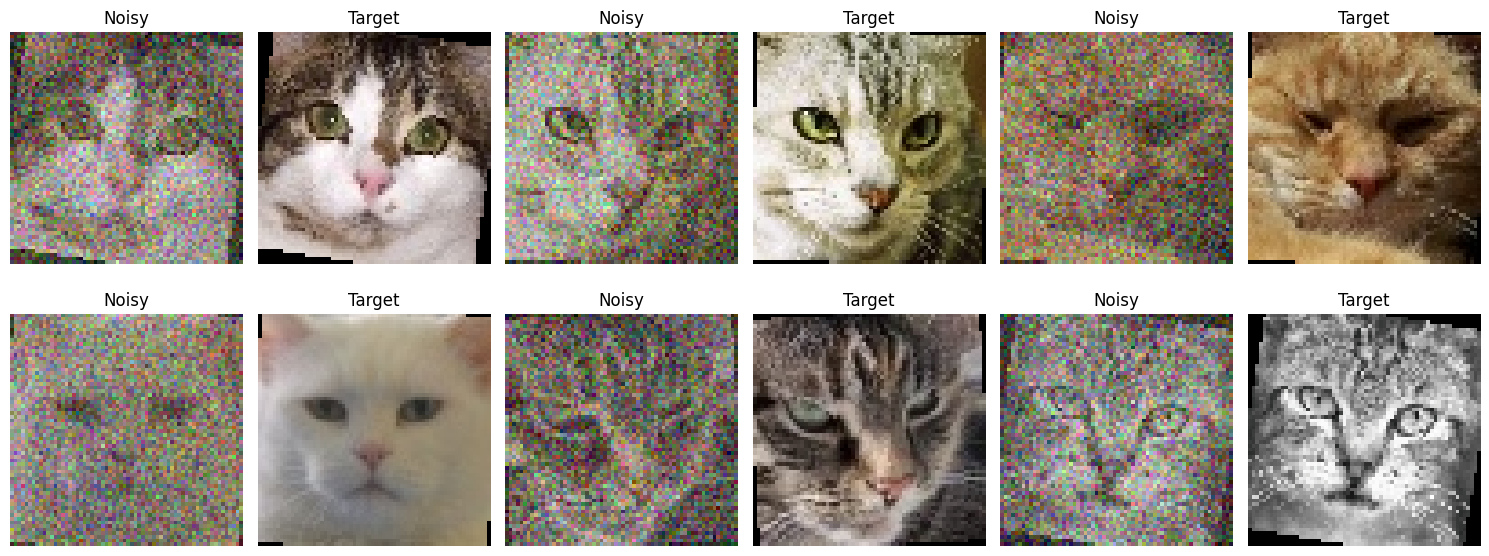

In [12]:
loader.plot_dataloader_samples(loader=train_loader, 
                               num_samples=6, 
                               random_samples=True)

➤ The Loss function, device, model and optimizer are defined. Note that the `Trainer` class we will use includes a `CosineAnnealing` scheduler for the learning rate, so the learning rate defined in the optimizer is the starting learning rate.

In [13]:
critertion = nn.MSELoss()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet().to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-4)

➤ The `Trainer` class is used to train an evaluate the model. Use `type='denoise'` to train a denoising model and `type='diffusion'` to train a diffusion model.

In [14]:
trainer = Trainer(model, 
                  optimizer=optimizer, 
                  critertion=critertion, 
                  device=device, 
                  type='denoise', 
                  noise_scheduler=noise_scheduler)

➤ Use `train()` to train the model. You can alternatively use `load_model()` to load a pre-trained model, and `save_model()` to save the model.

In [ ]:
trainer.train(train_loader, 
              val_loader, 
              num_epochs=5)

# trainer.load_model('model.pth')
# trainer.save_model('model.pth')

➤ Finally, you can use `plot_metrics()` to display the training and validation losses, and you can use `plot_examples()` to display some original, noisy and denoised images.

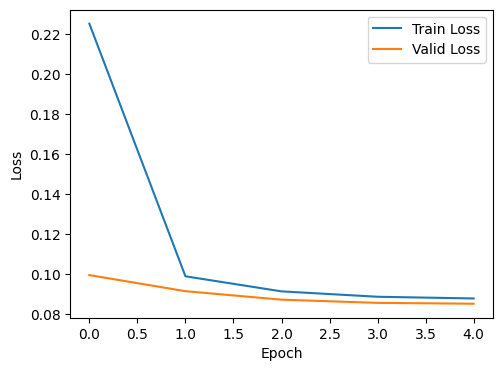

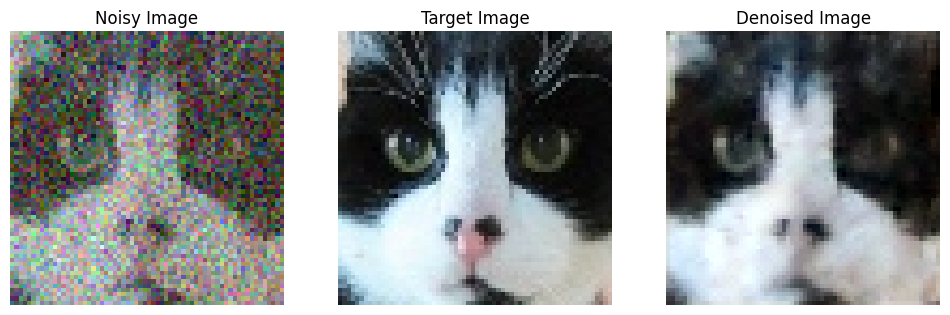

In [18]:
trainer.plot_metrics()
trainer.plot_examples(dataloader=test_loader, 
                      num_examples=1, 
                      predict_type='image') # Use 'image' or 'noise' depending on the task you specified in loader.configure_denoising()

<p style="text-align: center; font-size: 22px; font-weight: regular;">Diffusion tasks</p>

***

➤ The same steps as for denoising tasks are followed, until `loader.configure_denoising()` is called. This time, the `include_timestep` parameter is set to `True`. `predict_noise` is also set to `True` as this is mandatory for diffusion tasks.

In [21]:
loader.configure_denoising(predict_noise=True, 
                           include_timestep=True, 
                           noise_scheduler=noise_scheduler)

➤ Similar to denoising tasks, except the model used is a diffusion model, which takes the noise level as input in addition to the image.

In [22]:
train_loader, val_loader, test_loader = loader.prepare(augment=True, 
                                                       batch_size=32)

critertion = nn.MSELoss()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = UNet_Diffusion(image_channels=3,
                       hidden_dims=[64, 128, 256, 512],
                       time_emb_dim=32).to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-4)

➤ The Trainer is initialized with `type='diffusion'`.

In [23]:
trainer = Trainer(model, 
                  optimizer=optimizer, 
                  critertion=critertion, 
                  device=device, 
                  type='diffusion', 
                  noise_scheduler=noise_scheduler)

➤ The model is trained or loaded. You can find my pre-trained model after 50 and 150 epochs at the following link: https://drive.google.com/drive/folders/1DC_ZfGW4nyDfNmkQ0Oe32G0EI1qrRgSP?usp=sharing

In [ ]:
trainer.train(train_loader, 
              val_loader, 
              num_epochs=100)

#trainer.load_model('./pth/model_diffusion150epochs.pth')

Generating image: 100%|██████████| 1000/1000 [00:07<00:00, 128.19it/s]


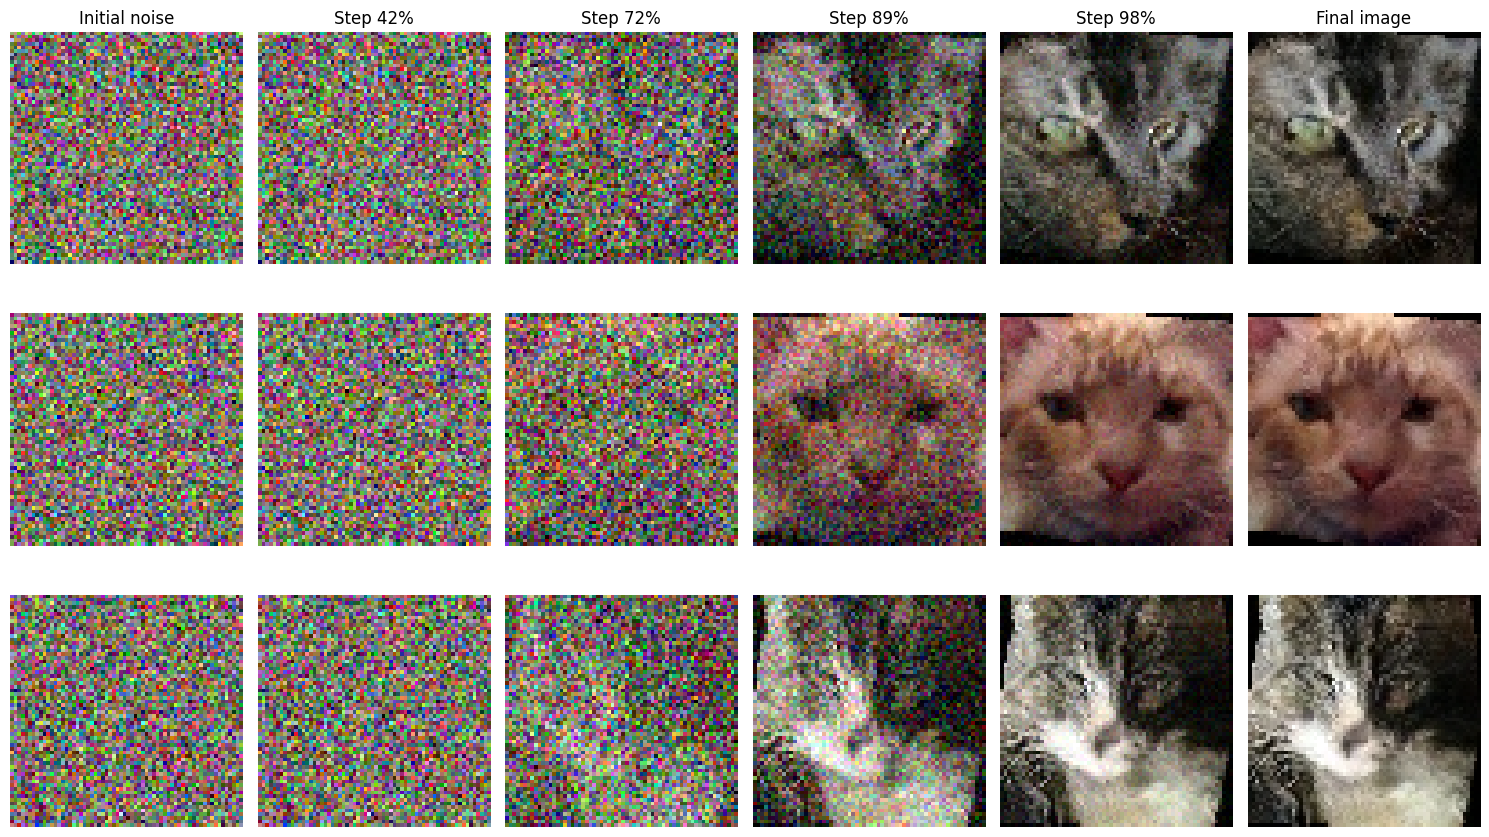

In [25]:
trainer.diffusion_inference(3)

Thank you for reading this notebook. If you have any questions or suggestions, feel free to ask.